In [1]:
# This cell only for package version control
import cirq
import qutip
import matplotlib
import sklearn
import sys

print('python    :', sys.version)
print('cirq version       :',cirq.__version__)
print('qutip version      :',qutip.__version__)
print('matplotlib version :',matplotlib.__version__)
print('sklearn version    :',sklearn.__version__)

python    : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
cirq version       : 0.13.1
qutip version      : 4.6.3
matplotlib version : 3.4.3
sklearn version    : 1.0.2


Probability theory is a cornerstone for machine learning. We can think of quantum states as probability distributions with certain properties that make them different from our classical notion of probabilities. Contrasting these properties is an easy and straightforward introduction to the most basic concepts we need in quantum computing.

Apart from probability theory, linear algebra is also critical for many learning protocols. As we will see, geometry and probabilities are intrinsically linked in quantum computing, but geometric notions are also familiar in dealing with classical probability distributions. This notebook first talks about classical probabilities and stochastic vectors, and introduces quantum states as a natural generalization.

Throughout this course, we will assume finite probability distributions and finite dimensional spaces. This significantly simplifies notation and most quantum computers operate over finite dimensional spaces, so we do not lose much in generality.


# Classical probability distributions

Let us toss a biased coin. Without getting too technical, we can associate a random variable $X$ with the output: it takes the value 0 for heads and the value 1 for tails. We get heads with probability $P(X=0) = p_0$ and tails with $P(X=1) = p_1$ for each toss of the coin. In classical, Kolmogorovian probability theory, $p_i\geq 0$ for all $i$, and the probabilities sum to one: $\sum_i p_i = 1$. Let's sample this distribution

In [3]:
import numpy as np
n_samples = 100
p_1 = 0.2
x_data = np.random.binomial(1, p_1, (n_samples,))
print(x_data)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We naturally expect that the empirically observed frequencies also sum to one:

In [4]:
frequency_of_zeros, frequency_of_ones = 0, 0
for x in x_data:
    if x:
        frequency_of_ones += 1/n_samples
    else:
        frequency_of_zeros += 1/n_samples
print(frequency_of_ones+frequency_of_zeros)

1.0000000000000004


Since $p_0$ and $p_1$ must be non-negative, all possible probability distributions are restricted to the positive orthant. The normalization constraint puts every possible distribution on a straight line. This plot describes all possible probability distributions by biased and unbiased coins.

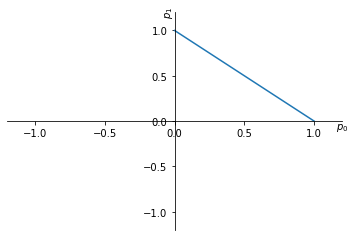

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
p_0 = np.linspace(0, 1, 100)
p_1 = 1-p_0
fig, ax = plt.subplots()
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlabel("$p_0$")
ax.xaxis.set_label_coords(1.0, 0.5)
ax.set_ylabel("$p_1$")
ax.yaxis.set_label_coords(0.5, 1.0)
plt.plot(p_0, p_1)

We may also arrange the probabilities in a vector $\vec{p} = \begin{bmatrix} p_0 \\ p_1 \end{bmatrix}$. Here, for notational convenience, we put an arrow above the variable representing the vector, to distinguish it from scalars. You will see that quantum states also have a standard notation that provides convenience, but goes much further in usefulness than the humble arrow here.

A vector representing a probability distribution is called a *stochastic vector*. The normalization constraint essentially says that the norm of the vector is restricted to one in the $l_1$ norm. In other words, $||\vec{p}||_1 = \sum_i |p_i| = 1$. This would be the unit circle in the $l_1$ norm, but since $p_i\geq 0$, we are restricted to a quarter of the unit circle, just as we plotted above. We can easily verify this with numpy's norm function:

In [6]:
p = np.array([[0.8], [0.2]])
np.linalg.norm(p, ord=1)

1.0

We know that the probability of heads is just the first element in the $\vec{p}$, but since it is a vector, we could use linear algebra to extract it. Geometrically, it means that we project the vector to the first axis. This projection is described by the matrix $\begin{bmatrix} 1 & 0\\0 & 0\end{bmatrix}$. The length in the $l_1$ norm gives the sought probability:

In [7]:
Π_0 = np.array([[1, 0], [0, 0]])
np.linalg.norm(Π_0 @ p, ord=1)

0.8

We can repeat the process to get the probability of tails:

In [8]:
Π_1 = np.array([[0, 0], [0, 1]])
np.linalg.norm(Π_1 @ p, ord=1)

0.2

The two projections play an equivalent role to the values 0 and 1 when we defined the probability distribution. In fact, we could define a new random variable called $\Pi$ that can take the projections $\Pi_0$ and $\Pi_1$ as values and we would end up with an identical probability distribution. This may sound convoluted and unnatural, but the measurement in quantum mechanics is essentially a random variable that takes operator values, such as projections.

What happens when we want to transform a probability distribution to another one? For instance, to change the bias of a coin, or to describe the transition of a Markov chain. Since the probability distribution is also a stochastic vector, we can apply a matrix on the vector, where the matrix has to fulfill certain conditions. A left *stochastic matrix* will map stochastic vectors to stochastic vectors when multiplied from the left: its columns add up to one. In other words, it maps probability distributions to probability distributions. For example, starting with a unbiased coin, the map $M$ will transform the distribution to a biased coin:

In [9]:
p = np.array([[.5], [.5]])
M = np.array([[0.7, 0.6], [0.3, 0.4]])
np.linalg.norm(M @ p, ord=1)

0.9999999999999999

One last concept that will come handy is entropy. A probability distribution's entropy is defined as $H(p) = - \sum_i p_i \log_2 p_i$. Let us plot it over all possible probability distributions of coin tosses:

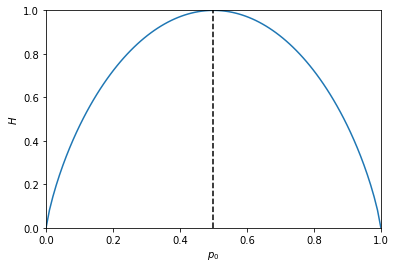

In [10]:
ϵ = 10e-10
p_0 = np.linspace(ϵ, 1-ϵ, 100)
p_1 = 1-p_0
H = -(p_0*np.log2(p_0) + p_1*np.log2(p_1))
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, -np.log2(0.5))
ax.set_xlabel("$p_0$")
ax.set_ylabel("$H$")
plt.plot(p_0, H)
plt.axvline(x=0.5, color='k', linestyle='--')

Here we can see that the entropy is maximal for the unbiased coin. This is true in general: the entropy peaks for the uniform distribution. In a sense, this is the most unpredictable distribution: if we get heads with probability 0.2, betting tails is a great idea. On the other hand, if the coin is unbiased, then a deterministic strategy is of little help in winning. Entropy quantifies this notion of surprise and unpredictability.

# Quantum states

A classical coin is a two-level system: it is either heads or tails. At a first look a quantum state is a probability distribution, and the simplest case is a two-level state, which we call a qubit. Just like the way we can write the probability distribution as a column vector, we can write a quantum state as a column vector. For notational convenience that will become apparent later, we write the label of a quantum state in what is called a ket in the Dirac notation. So for instance, for some qubit, we can write 

$$
|\psi\rangle = \begin{bmatrix}
    a_0 \\
    a_1 \\
\end{bmatrix}.
$$

In other words, a ket is just a column vector, exactly like the stochastic vector in the classical case. Instead of putting an arrow over the name of the variable to express that it is a vector, we use the ket to say that it is a column vector that represents a quantum state. There's more to this notation, as we will see.

The key difference to classical probability distributions and stochastic vectors is the normalization constraint. The square sum of their absolute values adds up to 1:

$$
\sqrt{|a_0|^2+|a_1|^2}=1,
$$

where $a_0, a_1\in \mathbb{C}$. In other words, we are normalizing in the $l_2$ norm instead of the $l_1$ norm. Furthermore, we are no longer restricted to the positive orthant: the components of the quantum state vector, which we call *probability amplitudes*, are complex valued.

Let us introduce two special qubits, corresponding to the canonical basis vectors in two dimensions: $|0\rangle$ and $|1\rangle$.

$$
|0\rangle = \begin{bmatrix}
    1 \\
    0 \\
\end{bmatrix}, \,\,\, |1\rangle = \begin{bmatrix}
    0 \\
    1 \\
\end{bmatrix}.
$$

This basis is also called the computational basis in quantum computing.

We can expand an arbitrary qubit state in this basis:

$$
|\psi\rangle = \begin{bmatrix}
    a_0 \\
    a_1 \\
\end{bmatrix}=a_0\begin{bmatrix}
    1 \\
    0 \\
\end{bmatrix} + 
a_1\begin{bmatrix}
    0 \\
    1 \\
\end{bmatrix}=
a_0|0\rangle+a_1|1\rangle.
$$

This expansion in a basis is called a superposition. If we sample the qubit state, we obtain the outcome 0 with probability $|a_0|^2$, and 1 with probability $|a_1|^2$. This is known as the Born rule; you will learn more about measurements and this rule in a subsequent notebook.

For now, let's take a look at how we can simulate classical coin tossing on a quantum computer. Let's start with a completely biased case where we get heads with probability 1. This means that our qubit $|\psi\rangle=|0\rangle$. We create a circuit of a single qubit and a single classical register where the results of the sampling (measurements) go.

In [11]:
import cirq
from cirq import GridQubit, Circuit, Simulator
from cirq_tools import *

import numpy as np
π = np.pi

simulator = Simulator()

q = GridQubit(0,0)
circuit = Circuit(
          cirq.I(q)
)

Any qubit is initialized in $|0\rangle$, so if we measure it right away, we should get our maximally biased coin.

In [12]:
circuit.append(cirq.measure(q, key='m'))

Let us execute it a hundred times and study the result

In [13]:
result = simulator.run(circuit, repetitions=100)
print(result.histogram(key='m'))

Counter({0: 100})


As expected, all of our outcomes are 0. To understand the possible quantum states, we use the Bloch sphere visualization. Since the probability amplitudes are complex and there are two of them for a single qubit, this would require a four-dimensional space. Now since the vectors are normalized, this removes a degree of freedom, allowing a three-dimensional representation with an appropriate embedding. This embedding is the Bloch sphere. It is slightly different than an ordinary sphere in three dimensions: we identify the north pole with the state $|0\rangle$, and the south pole with $|1\rangle$. In other words, two orthogonal vectors appear as if they were on the same axis -- the axis Z. The computational basis is just one basis: the axes X and Y represent two other bases. Any point on the surface of this sphere is a valid quantum state. This is also true the other way around: every pure quantum state is a point on the Bloch sphere. Here it 'pure' is an important technical term and it essentially means that the state is described by a ket (column vector). Later in the course we will see other states called mix states that are not described by a ket (you will see later that these are inside the Bloch sphere).

To make it less abstract, let's plot our $|0\rangle$ on the Bloch sphere:

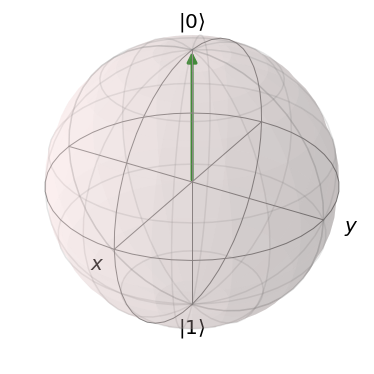

In [14]:
circuit = cirq.Circuit(
    cirq.measure(q, key='m')
)

result = simulator.simulate(circuit)
plot_quantum_state(result.final_state_vector)

Compare this sphere with the straight line in the positive orthant that describes all classical probability distributions of coin tosses. You can already see that there is a much richer structure in the quantum probability space.

Let us pick another point on the Bloch sphere, that is, another distribution. Let's transform the state $|0\rangle$ to $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. This corresponds to the unbiased coin, since we will get 0 with probability $|\frac{1}{\sqrt{2}}|^2=1/2$, and the other way around. There are many ways to do this transformation. We pick a rotation around the Y axis by $\pi/2$, which corresponds to the matrix $\frac{1}{\sqrt{2}}\begin{bmatrix} 1 & -1\\1 & 1\end{bmatrix}$.

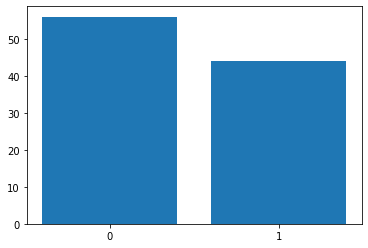

In [15]:
circuit = cirq.Circuit()
circuit.append(cirq.ry(π/2)(q))
circuit.append(cirq.measure(q, key='m'))
results = simulator.run(circuit, repetitions=100)
plot_histogram(results.histogram(key='m'))

To get an intuition why it is called a rotation around the Y axis, let's plot it on the Bloch sphere:

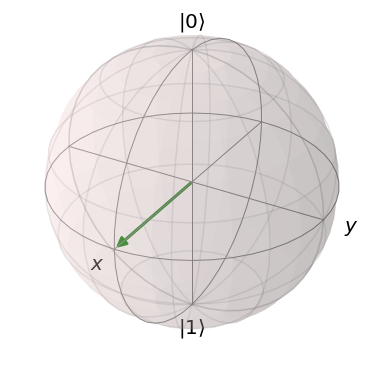

In [16]:
circuit = Circuit(
    cirq.ry(π/2)(q)
)

result = simulator.simulate(circuit)
plot_quantum_state(result.final_state_vector)

It does exactly what it says: it rotates from the north pole of the Bloch sphere.

Why is interesting to have complex probability amplitudes instead of non-negative real numbers? To get some insight, take a look what happens if we apply the same rotation to $|1\rangle$. To achieve this, first we flip $|0\rangle$ to $|1\rangle$ by applying a NOT gate (denoted by X in quantum computing) and then the rotation.

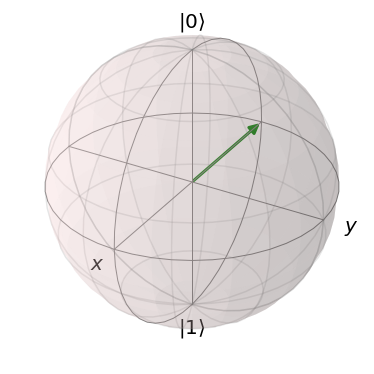

In [17]:
circuit = Circuit(
    cirq.X(q),
    cirq.ry(π/2)(q)
)

result = simulator.simulate(circuit)
plot_quantum_state(result.final_state_vector)

You can verify that the result is $\frac{1}{\sqrt{2}}(-|0\rangle + |1\rangle)$. That is, the exact same state as before, except that the first term got a minus sign: it is a negative probability amplitude. Note that the difference cannot be observed from the statistics:

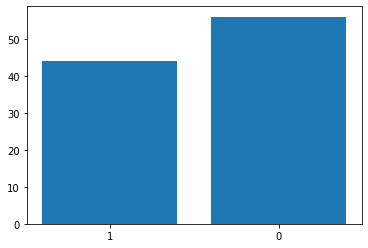

In [18]:
circuit = Circuit(
    cirq.X(q),
    cirq.ry(π/2)(q),
    cirq.measure(q, key='m')
)

results = simulator.run(circuit, repetitions=100)
plot_histogram(results.histogram(key='m'))

It still looks like an approximately unbiased coin. Yet, that negative sign -- or any complex value -- is what models *interference*, a critically important phenomenon where probability amplitudes can interact in a constructive or a destructive way. To see this, if we apply the rotation twice in a row on $|0\rangle$, we get another deterministic output, $|1\rangle$, although in between the two, it was some superposition. 

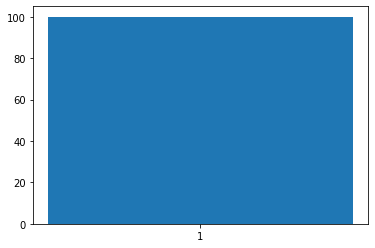

In [19]:
circuit = Circuit(
    cirq.ry(π/2)(q),
    cirq.ry(π/2)(q),
    cirq.measure(q, key='m')
)

results = simulator.run(circuit, repetitions=100)
plot_histogram(results.histogram(key='m'))

Many quantum algorithms exploit interference, for instance, the seminal [Deutsch-Josza algorithm](https://en.wikipedia.org/wiki/Deutsch–Jozsa_algorithm), which is among the simplest to understand its significance.

# More qubits and entanglement

We have already seen that quantum states are probability distributions normed to 1 in the $l_2$ norm and we got a first peek at interference. If we introduce more qubits, we see another crucial quantum effect emerging. To do that, we first have to define how we write down the column vector for describing two qubits. We use a tensor product, which, in the case of qubits, is equivalent to the Kronecker product. Given two qubits, $|\psi\rangle=\begin{bmatrix}a_0\\a_1\end{bmatrix}$ and $|\psi'\rangle=\begin{bmatrix}b_0\\b_1\end{bmatrix}$, their product is $|\psi\rangle\otimes|\psi'\rangle=\begin{bmatrix}a_0b_0\\ a_0b_1\\ a_1b_0\\ a_1b_1\end{bmatrix}$. Imagine that you have two registers $q_0$ and $q_1$, each can hold a qubit, and both qubits are in the state $|0\rangle$. Then this composite state would be described by according to this product rule as follows:

In [20]:
q0 = np.array([[1], [0]])
q1 = np.array([[1], [0]])
np.kron(q0, q1)

array([[1],
       [0],
       [0],
       [0]])

This is the $|0\rangle\otimes|0\rangle$ state, which we often abbreviate as $|00\rangle$. The states $|01\rangle$, $|10\rangle$, and $|11\rangle$ are defined analogously, and the four of them give the canonical basis of the four dimensional complex space, $\mathbb{C}^2\otimes\mathbb{C}^2$.

Now comes the interesting and counter-intuitive part. In machine learning, we also work with high-dimensional spaces, but we never construct it as a tensor product: it is typically $\mathbb{R}^d$ for some dimension $d$. The interesting part of writing the high-dimensional space as a tensor product is that not all vectors in can be written as a product of vectors in the component space.

Take the following state: $|\phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$. This vector is clearly in $\mathbb{C}^2\otimes\mathbb{C}^2$, since it is a linear combination of two of the basis vector in this space. Yet, it cannot be written as $|\psi\rangle\otimes|\psi'\rangle$ for some $|\psi\rangle$, $|\psi'\rangle\in\mathbb{C}^2$.

To see this, assume that it can be written in this form. Then

$$
|\phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) = \begin{bmatrix}a_0b_0\\ a_0b_1\\ a_1b_0\\ a_1b_1\end{bmatrix} = a_0b_0|00\rangle + a_0b_1|01\rangle + a_1b_0|10\rangle + a_1b_1|11\rangle.
$$

$|01\rangle$ and $|10\rangle$ do not appear on the left-hand side, so their coefficients must be zero: $a_1b_0=0$ and $a_0b_1=0$. This leads to a contradiction, since $a_1$ cannot be zero ($a_1b_1=1$), so $b_0$ must be zero, but $a_0b_0=1$. Therefore $|\phi^+\rangle$ cannot be written as a product.

States that cannot be written as a product are called entangled states. This is the mathematical form of describing a phenomenon of strong correlations between random variables that exceed what is possible classically. Entanglement plays a central role in countless quantum algorithms. A simple example is [quantum teleportation](https://en.wikipedia.org/wiki/Quantum_teleportation). We will also see its applications in quantum machine learning protocols.

We will have a closer look at entanglement in a subsequent notebook on measurements, but as a teaser, let us look at the measurement statistics of the $|\phi^+\rangle$ state. The explanation of the circuit preparing it will also come in a subsequent notebook.

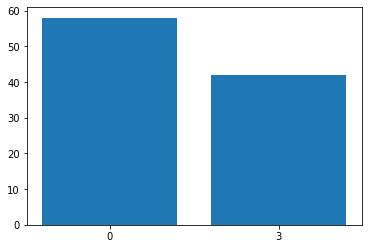

In [21]:
q0 = GridQubit(0,0)
q1 = GridQubit(0,1)

circuit = Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='m')
)
results = simulator.run(circuit, repetitions=100)
plot_histogram(results.histogram(key='m'))

Notice that 01 or 10 never appear in the measurement statistics.

# Further reading

Chapter 9 in Quantum Computing since Democritus by Scott Aaronson describes a similar approach to understanding quantum states -- in fact, the interference example was lifted from there.